# STRATEGY:

- Import files, clean (pre-processing), describe statistics and general info about features
- Feature engineering: derive new features according to metadata
- Calculate correlations between features and with class
    - We should remove features highly correlated with other features, and keep the high correlated with class
- Distribution of specific features with the class: histograms, density-plots, pivot-tables, scatter-plot
- Confusion matrix with simple classifiers

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
train.head()


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [10]:
#Statistical description of variables
train.describe(include='all')

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A658071,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [11]:
# See the column data types and non-missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [12]:
train["DateTime"]

0        2014-02-12 18:22:00
1        2013-10-13 12:44:00
2        2015-01-31 12:28:00
3        2014-07-11 19:09:00
4        2013-11-15 12:52:00
5        2014-04-25 13:04:00
6        2015-03-28 13:11:00
7        2015-04-30 17:02:00
8        2014-02-04 17:17:00
9        2014-05-03 07:48:00
10       2013-12-05 15:50:00
11       2013-11-04 14:48:00
12       2016-02-03 11:27:00
13       2015-06-08 16:30:00
14       2015-11-25 15:00:00
15       2014-07-12 12:10:00
16       2014-05-03 16:15:00
17       2014-06-07 12:54:00
18       2014-05-17 11:32:00
19       2014-07-30 17:34:00
20       2014-01-19 15:03:00
21       2015-09-18 15:19:00
22       2015-08-15 14:22:00
23       2013-10-28 16:32:00
24       2014-04-09 17:44:00
25       2015-10-03 15:44:00
26       2016-01-15 17:31:00
27       2015-03-25 18:50:00
28       2015-11-21 13:01:00
29       2015-07-30 14:30:00
                ...         
26699    2014-04-21 14:01:00
26700    2015-06-15 19:28:00
26701    2014-06-15 17:41:00
26702    2015-

In [19]:
%run functions.py
names = train["Name"].value_counts()
countings_values = train["Name"].value_counts().tolist()
minimum_counting = np.percentile(countings_values, 95, axis=0)

print(countings_values)

[136, 135, 107, 106, 94, 87, 86, 85, 68, 66, 61, 58, 57, 57, 55, 55, 54, 53, 53, 52, 51, 50, 48, 48, 47, 46, 45, 44, 44, 44, 43, 43, 42, 42, 41, 40, 40, 39, 38, 38, 38, 38, 37, 36, 36, 36, 35, 35, 35, 35, 34, 34, 34, 33, 32, 32, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 29, 29, 29, 28, 28, 28, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,

In [6]:
df =process_name(train)
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Unknown_Name,Common_Name
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,0,1
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,0
3,A683430,Unknown,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0
4,A667013,Unknown,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,1,0


In [ ]:
#Deal with dates
#https://medium.com/jbennetcodes/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f 

## Pre-processing and observing dataset

In [57]:
%run functions.py
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
holdout=pre_process(holdout)

print(train.head())
print(train.info())



/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:27: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  def column_split(df,column,sep,n,new_col):


  AnimalID      OutcomeType  YearTime  Weekend  Christmas  Summer  Winter  \
0  A671945  Return_to_owner      2014        0          0       0       1   
1  A656520       Euthanasia      2013        1          0       0       0   
2  A686464         Adoption      2015        1          0       0       1   
3  A683430         Transfer      2014        0          0       1       0   
4  A667013         Transfer      2013        0          0       0       0   

       Hour_sin      Hour_cos     Month_sin       ...        \
0 -1.000000e+00 -1.836970e-16  5.000000e-01       ...         
1 -2.588190e-01 -9.659258e-01 -1.000000e+00       ...         
2  1.224647e-16 -1.000000e+00  0.000000e+00       ...         
3 -9.659258e-01  2.588190e-01  1.224647e-16       ...         
4 -2.588190e-01 -9.659258e-01 -8.660254e-01       ...         

   intelligence_lowest  no_colours_bicolour  no_colours_multicolour  \
0                    0                    1                       0   
1               

In [53]:
train.describe(include='all')

,AnimalID,OutcomeType,YearTime,Weekend,Christmas,Summer,Winter,Hour_sin,Hour_cos,Month_sin,...,intelligence_lowest,no_colours_bicolour,no_colours_multicolour,common_colour_90,common_colour_92,common_colour_95,common_colour_98,TimeOfDay_Afternoon,TimeOfDay_Evening,AnimalType_Dog
count,26729,26729,26729.000000,26729.00000,26729.000000,26729.000000,26729.0,26729.000000,2.672900e+04,26729.000000,...,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
unique,26729,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,A714852,Adoption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,10769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2014.430731,0.32403,0.087919,0.336750,0.0,-0.551017,-4.652322e-01,-0.092140,...,0.026338,0.513861,0.034120,0.835460,0.787310,0.647948,0.413446,0.760822,0.124621,0.583449
std,NaN,NaN,0.741408,0.46802,0.283183,0.472608,0.0,0.511530,4.672199e-01,0.692155,...,0.160143,0.499817,0.181541,0.370772,0.409218,0.477619,0.492461,0.426590,0.330295,0.492996
min,NaN,NaN,2013.000000,0.00000,0.000000,0.000000,0.0,-1.000000,-1.000000e+00,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,2014.000000,0.00000,0.000000,0.000000,0.0,-0.965926,-8.660254e-01,-0.866025,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,NaN,NaN,2014.000000,0.00000,0.000000,0.000000,0.0,-0.707107,-5.000000e-01,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,NaN,NaN,2015.000000,1.00000,0.000000,1.000000,0.0,-0.258819,-1.836970e-16,0.500000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000


### Numerical Features

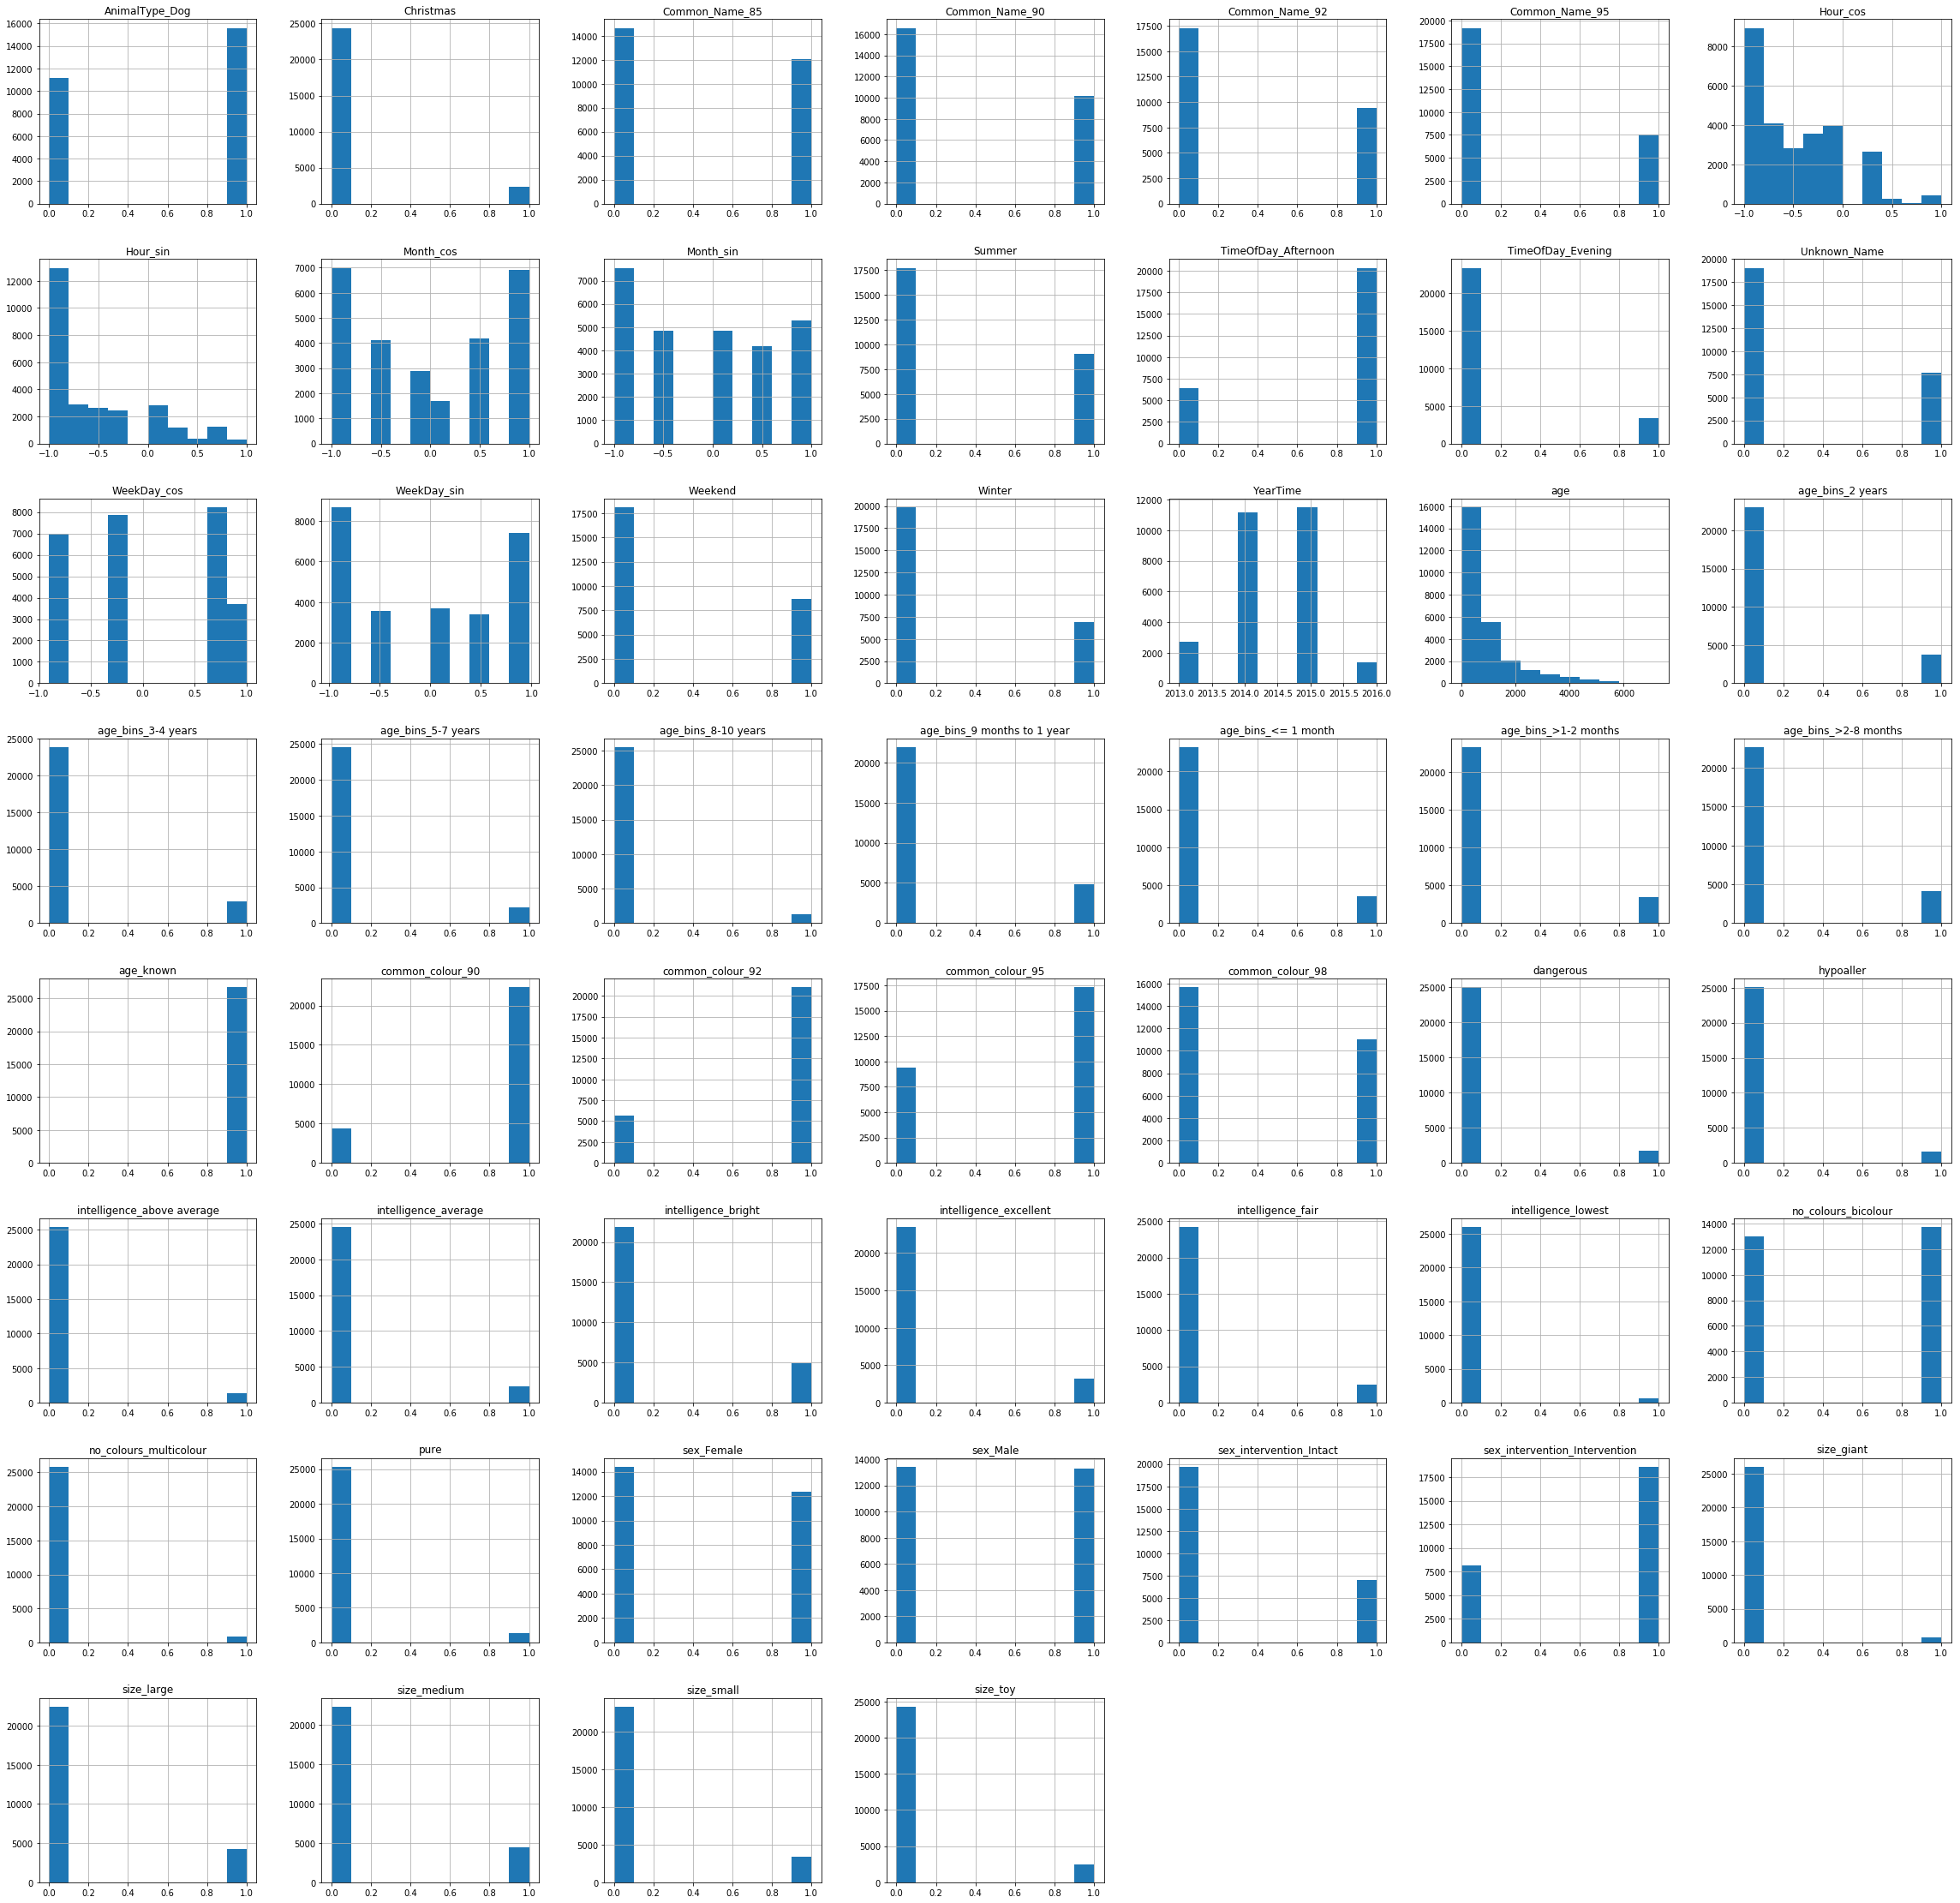

In [58]:
#histograms for each variable in df
hist = train.hist(bins=10,figsize =(40,40))

## Class Distribution

/home/andreia/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


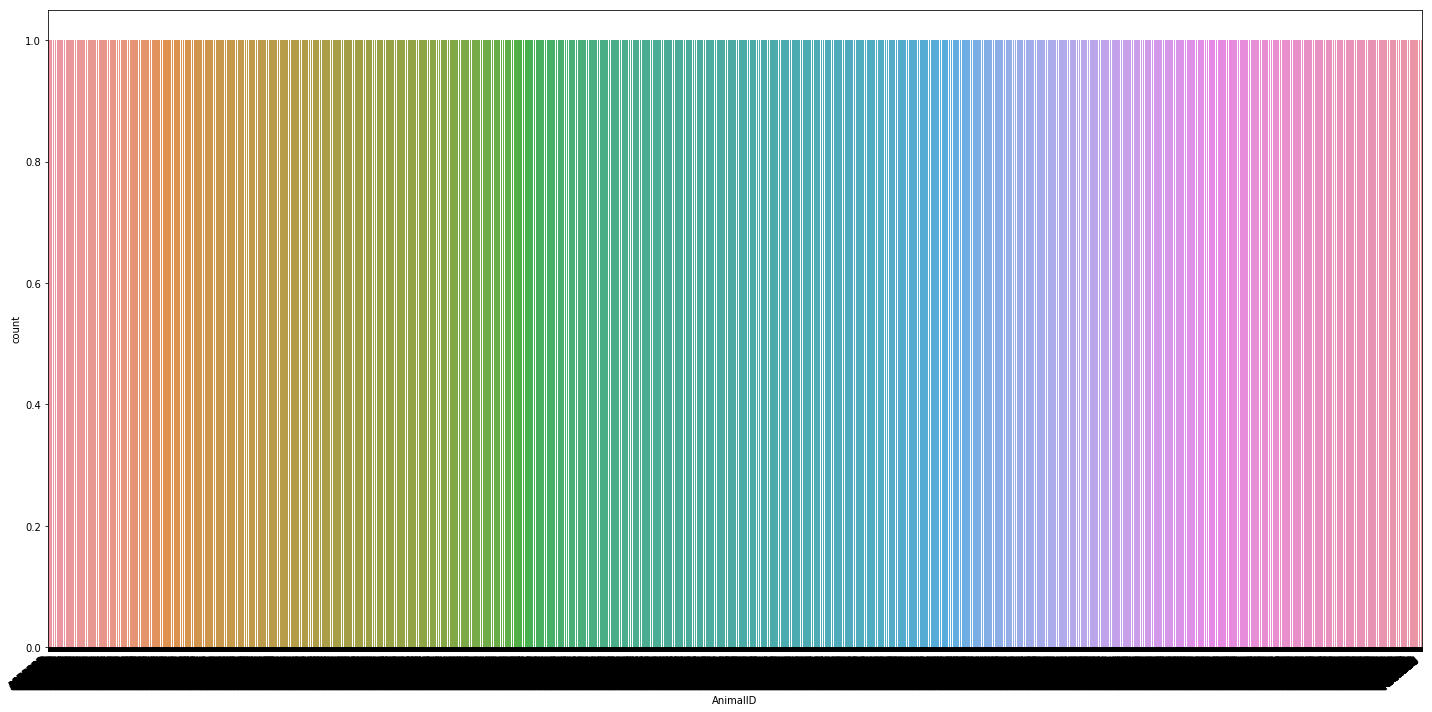

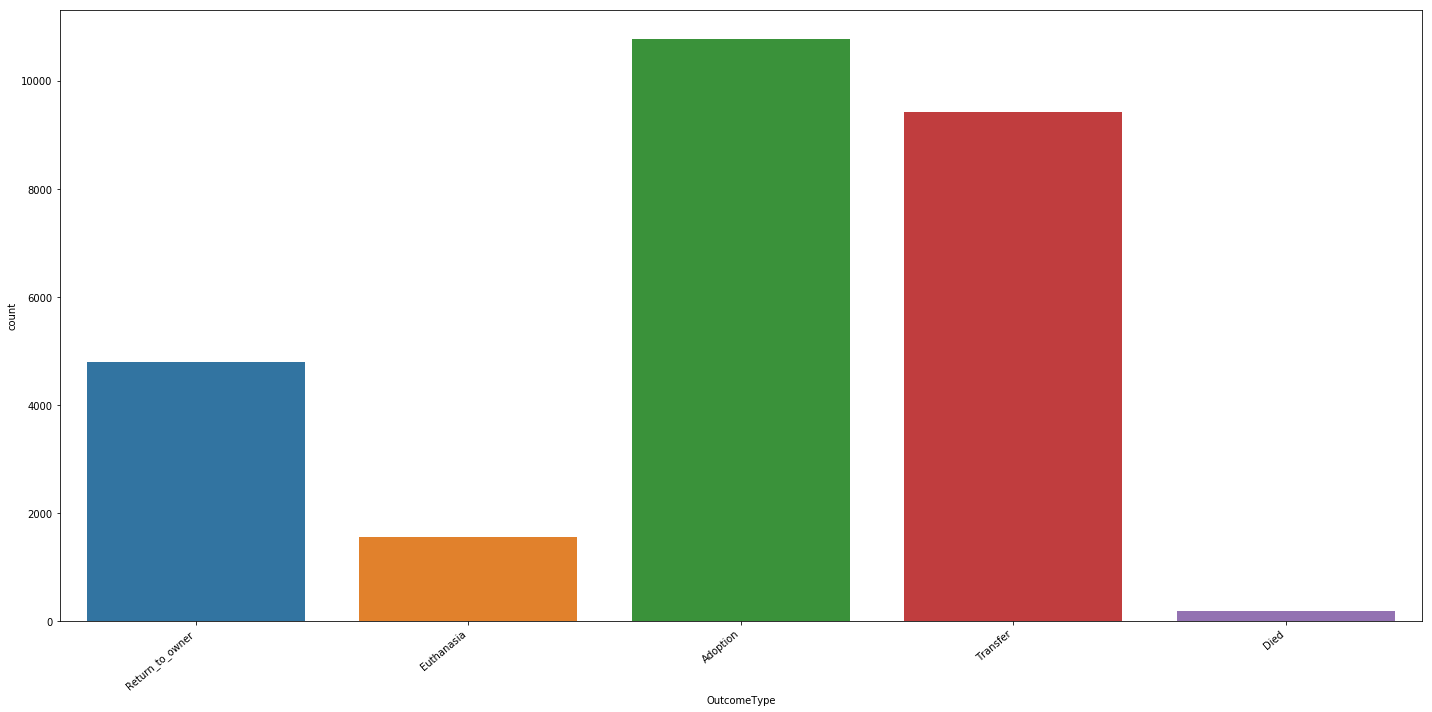

In [59]:
#select categorical variables only
df_cat = train.select_dtypes(include = 'object').copy()

for ColumnName in df_cat.columns:   
    fig, ax =plt.subplots(1, figsize=(20, 10))
    #get counts of each variable value
    df_cat[ColumnName].value_counts()
    #count plot for one variable
    ax = sns.countplot(x = df_cat[ColumnName], ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")    
    fig.tight_layout()
    fig.show()

## Polynomial FEng

In [27]:
from sklearn import preprocessing as pp
df=train.copy()
numerical=df.select_dtypes(include=['int', 'uint8', 'float', 'float64'])
df=df[numerical.columns]
    
poly = pp.PolynomialFeatures(2)
output_nparray = poly.fit_transform(df)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df.columns,p) for p in poly.powers_]]
output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
poly.get_feature_names(df.columns)
#['1', 'a', 'b', 'c', 'a^2', 'a b', 'a c', 'b^2', 'b c', 'c^2']

['1',
 'DayTime',
 'YearTime',
 'Hour_sin',
 'Hour_cos',
 'Month_sin',
 'Month_cos',
 'WeekDay_sin',
 'WeekDay_cos',
 'Unknown_Name',
 'Common_Name',
 'TimeOfDay_Afternoon',
 'TimeOfDay_Evening',
 'TimeOfDay_Morning',
 'AnimalType_Cat',
 'AnimalType_Dog',
 'DayTime^2',
 'DayTime YearTime',
 'DayTime Hour_sin',
 'DayTime Hour_cos',
 'DayTime Month_sin',
 'DayTime Month_cos',
 'DayTime WeekDay_sin',
 'DayTime WeekDay_cos',
 'DayTime Unknown_Name',
 'DayTime Common_Name',
 'DayTime TimeOfDay_Afternoon',
 'DayTime TimeOfDay_Evening',
 'DayTime TimeOfDay_Morning',
 'DayTime AnimalType_Cat',
 'DayTime AnimalType_Dog',
 'YearTime^2',
 'YearTime Hour_sin',
 'YearTime Hour_cos',
 'YearTime Month_sin',
 'YearTime Month_cos',
 'YearTime WeekDay_sin',
 'YearTime WeekDay_cos',
 'YearTime Unknown_Name',
 'YearTime Common_Name',
 'YearTime TimeOfDay_Afternoon',
 'YearTime TimeOfDay_Evening',
 'YearTime TimeOfDay_Morning',
 'YearTime AnimalType_Cat',
 'YearTime AnimalType_Dog',
 'Hour_sin^2',
 'Hour_s

## TPOT 

In [ ]:
#https://epistasislab.github.io/tpot/using/#parallel-training-with-dask 
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))

In [ ]:
pipeline_optimizer.export('tpot_exported_pipeline.py')

## CLASSIFICATION

In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Baseline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
%run functions.py

train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

train=train.drop(['AnimalID'], axis=1)

models=[KNeighborsClassifier(), RandomForestClassifier(), LinearSVC(multi_class='crammer_singer'), MLPClassifier(), LogisticRegression()]
names=["knn", "rf", 'svm', 'nn', 'lr']

X = train.drop(['OutcomeType'], axis=1)
y = train['OutcomeType']

i=0
for m in models:
    cv_results = cross_validate(m, X, y, cv=5)
    score = cv_results['test_score'].mean()  
    print(names[i])
    print(score)
    i+=1


knn
0.6132660782783885
rf
0.6662804231303154
svm
0.47549749947219244
nn
0.572294806688839
lr
0.6486597358631487


In [11]:
#USING SCORING LOG LOSS
%run functions.py
train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

df = train.copy()
classify(df, 'OutcomeType')


knn
4.337398093365498
rf
2.3448122979880477
nn
1.3507468162666776
lr
0.8554841531680154


In [8]:
# XGBOoost

%run functions.py
train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

df = train.copy()
train_XGBoost(df, 'OutcomeType', mode='ovr')

      AnimalID  OutcomeType
0      A671945            3
1      A656520            2
2      A686464            0
3      A683430            4
4      A667013            4
5      A677334            4
6      A699218            4
7      A701489            4
8      A671784            0
9      A677747            0
10     A668402            4
11     A666320            0
12     A684601            0
13     A704702            3
14     A688584            3
15     A678825            0
16     A678050            4
17     A680028            4
18     A679010            4
19     A684787            3
20     A670658            4
21     A708812            4
22     A705262            0
23     A665781            0
24     A676333            3
25     A712750            4
26     A718832            0
27     A698777            0
28     A715348            0
29     A708666            3
...        ...          ...
26699  A676460            2
26700  A704999            3
26701  A678842            4
26702  A713637      

/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:55: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[column] = df[column].convert_objects(convert_numeric=True)
/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:747: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[chosen_class] = enc.fit_transform(y[chosen_class])


Log-loss: -0.7803910756408138


## Balancing

In [28]:
%run functions.py
train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

df = train.copy()
print(df['OutcomeType'].value_counts())
df = balance_dataset(df, 'OutcomeType')
print(df['OutcomeType'].value_counts())

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64
IMPORTANT: Number of rows increased to 27289 due to balancement techniques

IMPORTANT: Number of rows increased to 31080 due to balancement techniques

IMPORTANT: Number of rows decreased to 25657 due to balancement techniques

IMPORTANT: Number of rows decreased to 21581 due to balancement techniques

IMPORTANT: Number of rows increased to 26730 due to balancement techniques

Transfer           5346
Euthanasia         5346
Died               5346
Adoption           5346
Return_to_owner    5346
Name: OutcomeType, dtype: int64


In [31]:
classify(df, 'OutcomeType')

knn
0.7141778411127528
rf
0.858883715237404
svm
0.3478036421496201
nn
0.4647599381026901
lr
0.5208008532736507


In [3]:
# WITH LOG LOSS

%run functions.py
train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

df = train.copy()
print(df['OutcomeType'].value_counts())
df = balance_dataset(df, 'OutcomeType')
print(df['OutcomeType'].value_counts())
classify(df, 'OutcomeType')

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64
IMPORTANT: Number of total rows increased to 27289 due to balancement techniques in class Return_to_owner 

IMPORTANT: Number of total rows increased to 31080 due to balancement techniques in class Euthanasia 

IMPORTANT: Number of total rows decreased to 25657 due to balancement techniques for class Adoption 

IMPORTANT: Number of total rows decreased to 21581 due to balancement techniques for class Transfer 

IMPORTANT: Number of total rows increased to 26730 due to balancement techniques in class Died 

Return_to_owner    5346
Euthanasia         5346
Adoption           5346
Died               5346
Transfer           5346
Name: OutcomeType, dtype: int64
knn
2.7399156092653834
rf
0.899272166573214
nn
1.7014700249488162
lr
1.1370746534961178


In [4]:
# XGBOoost
%run functions.py
train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

df = train.copy()
print(df['OutcomeType'].value_counts())
df = balance_dataset(df, 'OutcomeType')
print(df['OutcomeType'].value_counts())
train_XGBoost(df, 'OutcomeType', mode='ovr')

/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:55: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[column] = df[column].convert_objects(convert_numeric=True)


Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64
IMPORTANT: Number of total rows increased to 27289 due to balancement techniques in class Return_to_owner 

IMPORTANT: Number of total rows increased to 31080 due to balancement techniques in class Euthanasia 

IMPORTANT: Number of total rows decreased to 25657 due to balancement techniques for class Adoption 

IMPORTANT: Number of total rows decreased to 21581 due to balancement techniques for class Transfer 

IMPORTANT: Number of total rows increased to 26730 due to balancement techniques in class Died 

Died               5346
Euthanasia         5346
Adoption           5346
Return_to_owner    5346
Transfer           5346
Name: OutcomeType, dtype: int64
      AnimalID  OutcomeType
20062  A719111            3
19296  A706150            3
7515   A649442            3
22813  A643201            3
8832   A679596            3
502    A695

/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:747: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[chosen_class] = enc.fit_transform(y[chosen_class])


Log-loss: -0.9510864162448971


In [6]:
# XGBOoost

%run functions.py
train = pd.read_csv("train.csv")
#holdout = pd.read_csv("test.csv")
    
train=pre_process(train)
#holdout=pre_process(holdout)

df = train.copy()
print(df['OutcomeType'].value_counts())
df = balance_dataset(df, 'OutcomeType')
print(df['OutcomeType'].value_counts())
train_XGBoost(df, 'OutcomeType', mode='ovo')

/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:55: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[column] = df[column].convert_objects(convert_numeric=True)


Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64
IMPORTANT: Number of total rows increased to 27289 due to balancement techniques in class Return_to_owner 

IMPORTANT: Number of total rows increased to 31080 due to balancement techniques in class Euthanasia 

IMPORTANT: Number of total rows decreased to 25657 due to balancement techniques for class Adoption 

IMPORTANT: Number of total rows decreased to 21581 due to balancement techniques for class Transfer 

IMPORTANT: Number of total rows increased to 26730 due to balancement techniques in class Died 

Died               5346
Euthanasia         5346
Adoption           5346
Return_to_owner    5346
Transfer           5346
Name: OutcomeType, dtype: int64
      AnimalID  OutcomeType
20062  A719111            3
19296  A706150            3
7515   A649442            3
22813  A643201            3
8832   A679596            3
502    A695

/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:747: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  y[chosen_class] = enc.fit_transform(y[chosen_class])


AttributeError: 'OneVsOneClassifier' object has no attribute 'predict_proba'

## Tuning

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 

%run functions.py

train = pd.read_csv("train.csv")

train=pre_process(train)

train=train.drop(['AnimalID'])

knn={
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
}

rf={
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
}

lr={
    "name": "LogisticrRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"]
    }
}

models=[knn, rf, lr]
X = train.drop(['OutcomeType'], axis=1)
y = train['OutcomeType']

for dic in models:
    model = dic['estimator']
    hyperparamenters = dic['hyperparameters']
    grid = GridSearchCV(model, param_grid=hyperparamenters, cv=10)

    grid.fit(X, y)
    print(grid.best_params_)
    print(grid.best_score_)



/home/andreia/Documents/Data Science Challenges/KaggleCompetitions/Animals Shelter/functions.py:27: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[column] = df[column].convert_objects(convert_numeric=True)


KeyboardInterrupt: 

In [51]:
holdout = pd.read_csv("test.csv")
holdout=pre_process(holdout)  
x=holdout

cls=RandomForestClassifier(criterion='gini', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 9)

cls.fit(X, Y)
predictions=cls.predict(x)
